In [120]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    top_k_accuracy_score, 
    f1_score, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import LabelBinarizer

In [5]:
ORIGINAL_TRAIN_DIR = '../data/train/'
ORIGINAL_TEST_DIR = '../data/test/'

TRAIN_DIR = '../data/train_processed/'
TEST_DIR = '../data/test_processed/'

ORGINAL_CLASSES = 7 # Original number of classes (Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral)
IMG_SIZE = 48 # Image dimensions (48x48 pixels)
CHANNELS = 1 # Grayscale images have 1 channel

CLASSES = 6

Counting data

In [6]:
def count_data(directory):
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return

    counts = {}
    for emotion in sorted(os.listdir(directory)):
        path = os.path.join(directory, emotion)
        if os.path.isdir(path):
            counts[emotion] = len(os.listdir(path))
            print(f"{emotion}: {counts[emotion]}")
    
    return counts

In [7]:
org_train_stats = count_data(ORIGINAL_TRAIN_DIR)

angry: 3995
disgust: 436
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171


In [8]:
org_test_stats = count_data(ORIGINAL_TEST_DIR)

angry: 958
disgust: 111
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


In [25]:
def copy_dataset(source_dir, target_dir):
    if not os.path.exists(target_dir):
        print(f"Creating working copy: '{target_dir}'...")
        shutil.copytree(source_dir, target_dir)
        print("Copied")
    else:
        print(f"Skipping copy: '{target_dir}' already exists")

In [26]:
copy_dataset(ORIGINAL_TRAIN_DIR, TRAIN_DIR)
copy_dataset(ORIGINAL_TEST_DIR, TEST_DIR)

Creating working copy: '../data/train_processed/'...
Copied
Creating working copy: '../data/test_processed/'...
Copied


In [33]:
def merge_classes(base_dir, source_class, target_class):
    source_path = os.path.join(base_dir, source_class)
    target_path = os.path.join(base_dir, target_class)
    
    if not os.path.exists(source_path):
        print(f"Source folder '{source_class}' not found in '{base_dir}'")
        return

    print(f"Merging '{source_class}' -> '{target_class}' in '{base_dir}'...")
    files = os.listdir(source_path)
    
    for file in files:
        src_file = os.path.join(source_path, file)
        dst_file = os.path.join(target_path, file)        

        shutil.move(src_file, dst_file)
        
    os.rmdir(source_path)
    print(f" Moved {len(files)} files. Folder '{source_class}' removed")

In [29]:
merge_classes(TRAIN_DIR, source_class='disgust', target_class='angry')
merge_classes(TEST_DIR, source_class='disgust', target_class='angry')

Merging 'disgust' -> 'angry' in '../data/train_processed/'...
 Moved 436 files. Folder 'disgust' removed
Merging 'disgust' -> 'angry' in '../data/test_processed/'...
 Moved 111 files. Folder 'disgust' removed


In [9]:
train_stats = count_data(TRAIN_DIR)

angry: 4431
fear: 4097
happy: 7215
neutral: 4965
sad: 4830
surprise: 3171


In [10]:
test_stats = count_data(TEST_DIR)

angry: 1069
fear: 1024
happy: 1774
neutral: 1233
sad: 1247
surprise: 831


In [11]:
def plot_samples(directory, num_samples):
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return
    
    classes = sorted(os.listdir(directory))
    
    plt.figure(figsize=(15, 18))
    plt.suptitle("Sample Images from Processed Dataset", fontsize=16)

    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
            
        all_images = os.listdir(class_path)
        sample_images = random.sample(all_images, num_samples)
            
        for j, image_name in enumerate(sample_images):
            img_path = os.path.join(class_path, image_name)
            img = imread(img_path)
            
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            
            if j == 0:
                plt.title(class_name, fontsize=12, fontweight='bold', loc='left')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

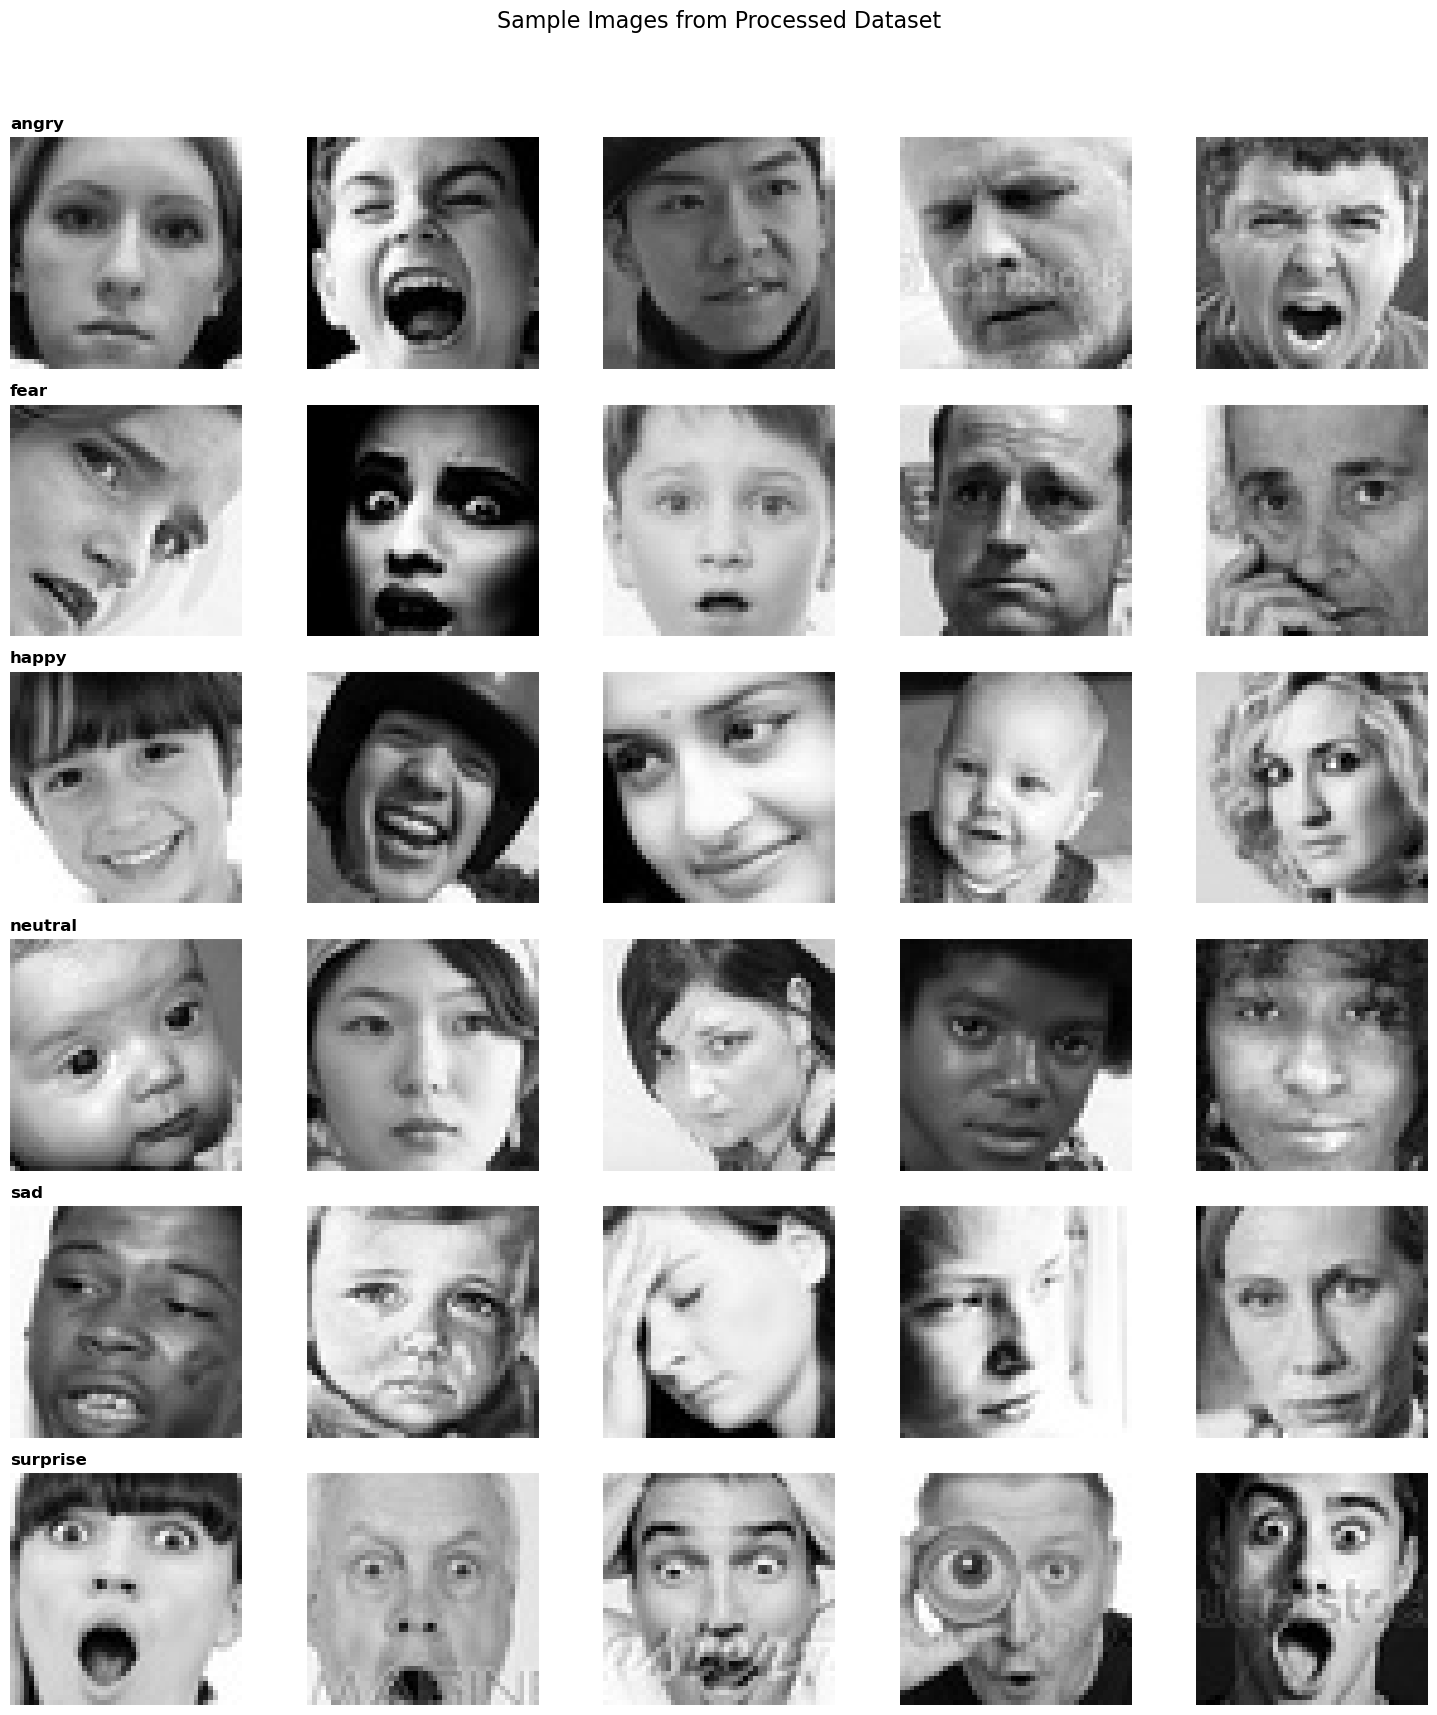

In [51]:
plot_samples(TRAIN_DIR, 5)

In [13]:
BATCH_SIZE = 64
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=5,        # Random rotation up to 5 degrees
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.1,         
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

print("Loading Test Data...")
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Classes found: {list(train_generator.class_indices.keys())}")

Loading Training Data...
Found 28709 images belonging to 6 classes.
Loading Test Data...
Found 7178 images belonging to 6 classes.
Classes found: ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
def build_cnn_model(input_shape, num_classes):
    model = Sequential()

    model.add(Input(shape=input_shape))

    # Block 1: low level features like edges
    # 32 filters, 3x3 kernel size
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv1'))
    model.add(BatchNormalization(name='block1_batchnorm'))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='block1_conv2'))
    model.add(BatchNormalization(name='block1_batchnorm2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block1_pool'))
    model.add(Dropout(0.25, name='block1_dropout')) # Drop 25% of neurons to prevent overfitting

    # Block 2: mid level features like shapes
    # Increasing filters to 64
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='block2_conv1'))
    model.add(BatchNormalization(name='block2_batchnorm'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block2_pool'))
    model.add(Dropout(0.25, name='block2_dropout'))

    # Block 3: high level features like whole eyes/mouths
    # Increasing filters to 128
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='block3_conv1'))
    model.add(BatchNormalization(name='block3_batchnorm'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='block3_pool'))
    model.add(Dropout(0.25, name='block3_dropout'))

    # Block 4
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(128, activation='relu', name='dense_1'))
    model.add(BatchNormalization(name='dense_1_batchnorm'))
    model.add(Dropout(0.5, name='dense_1_dropout'))

    model.add(Dense(num_classes, activation='softmax', name='output_layer'))

    return model

In [ ]:
input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
model = build_cnn_model(input_shape, CLASSES)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_batchnorm                │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_batchnorm2               │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_dropout (Dropout)        │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_batchnorm                │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_dropout (Dropout)        │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_batchnorm                │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_dropout (Dropout)        │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_batchnorm               │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1_dropout (Dropout)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 694,182 (2.65 MB)

 Trainable params: 693,414 (2.65 MB)

 Non-trainable params: 768 (3.00 KB)

In [52]:
EPOCHS = 40

checkpoint = ModelCheckpoint(
    'my_model.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, 
    patience=4, 
    min_lr=1e-6,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping, reduce_lr]

In [61]:
# --- START TRAINING ---

print("Starting training...")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

print("Training finished.")

Starting training...
Epoch 1/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.4546 - loss: 1.3850
Epoch 1: val_accuracy improved from 0.26158 to 0.48077, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 114s 253ms/step - accuracy: 0.4584 - loss: 1.3745 - val_accuracy: 0.4808 - val_loss: 1.3629 - learning_rate: 0.0010
Epoch 2/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4767 - loss: 1.3346
Epoch 2: val_accuracy improved from 0.48077 to 0.50683, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.4814 - loss: 1.3202 - val_accuracy: 0.5068 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 3/40
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.5013 - loss: 1.2786
Epoch 3: val_accuracy improved from 0.50683 to 0.52243, saving model to best_emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 252ms/step - accuracy: 0.5048 - loss: 1.2776 - val_accuracy: 0.5224 - val_loss: 1.2888 - learning_ra

In [56]:
model_filename = 'my_model.keras'

if os.path.exists(model_filename):
    model = load_model(model_filename)
    print(f"Model loaded successfully from {model_filename}")
else:
    raise FileNotFoundError(f"File {model_filename} not found.")

Model loaded successfully from my_model.keras


In [57]:
if 'validation_generator' in locals():
    validation_generator.reset()
    
    y_prob = model.predict(validation_generator, verbose=1)
    
    y_pred = np.argmax(y_prob, axis=1)
    y_true = validation_generator.classes
    
    class_labels = list(validation_generator.class_indices.keys())
    n_classes = len(class_labels)
else:
    print("Error: 'validation_generator' not defined")

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step


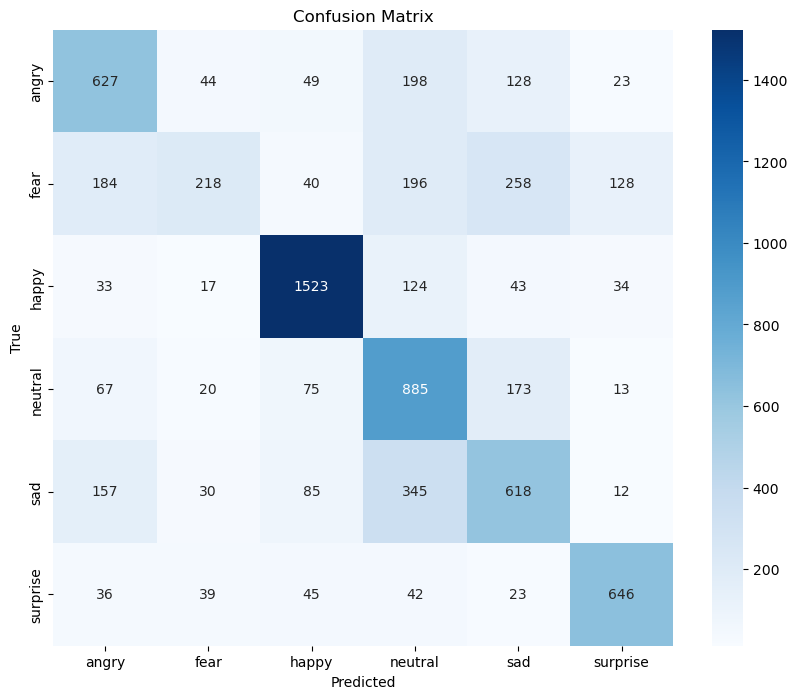

              precision    recall  f1-score   support

       angry       0.57      0.59      0.58      1069
        fear       0.59      0.21      0.31      1024
       happy       0.84      0.86      0.85      1774
     neutral       0.49      0.72      0.59      1233
         sad       0.50      0.50      0.50      1247
    surprise       0.75      0.78      0.77       831

    accuracy                           0.63      7178
   macro avg       0.62      0.61      0.60      7178
weighted avg       0.63      0.63      0.62      7178



In [60]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, 
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_labels))

In [62]:
acc = accuracy_score(y_true, y_pred)
print(f"Standard Accuracy: {acc:.4f} ({acc*100:.2f}%)")

top2_acc = top_k_accuracy_score(y_true, y_prob, k=2)
print(f"Top-2 Accuracy:    {top2_acc:.4f} ({top2_acc*100:.2f}%)")

f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1-Score (Weighted): {f1:.4f}")

Standard Accuracy: 0.6293 (62.93%)
Top-2 Accuracy:    0.8164 (81.64%)
F1-Score (Weighted): 0.6157


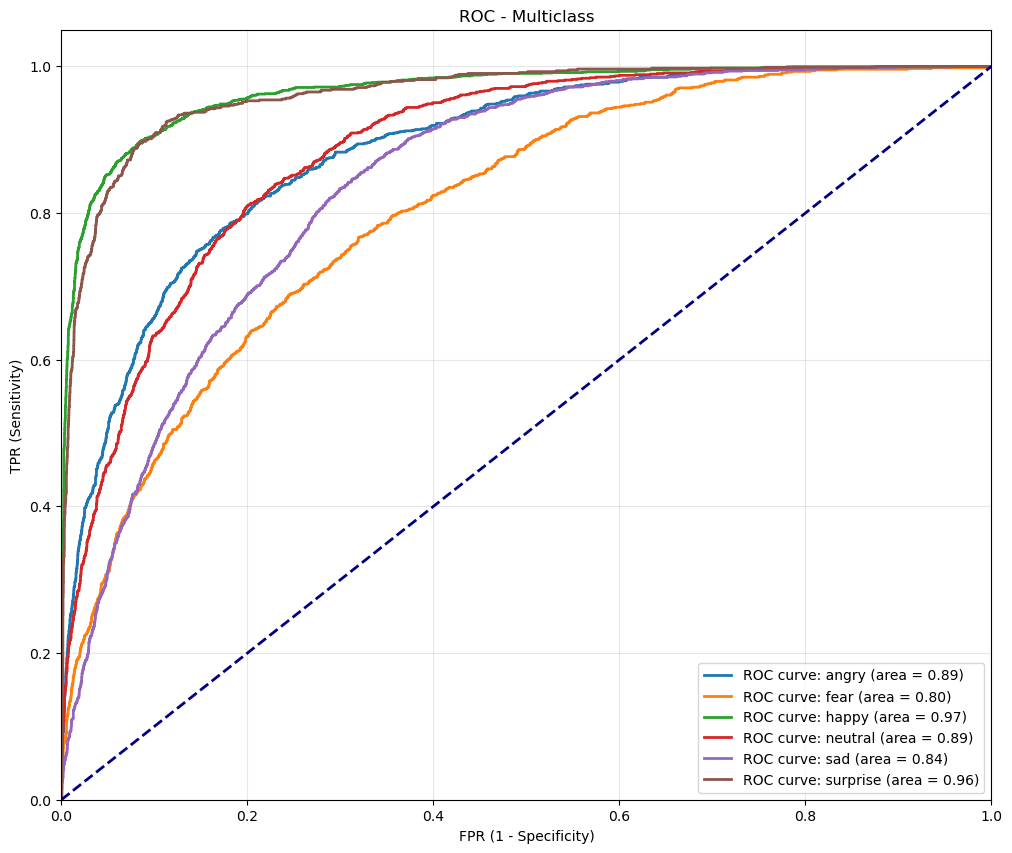

In [63]:
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {class_labels[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (1 - Specificity)')
plt.ylabel('TPR (Sensitivity)')
plt.title('ROC - Multiclass')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print("Initializing SHAP GradientExplainer...")

batch1 = next(train_generator)[0]
batch2 = next(train_generator)[0]
background = np.concatenate([batch1, batch2])[:100]

explainer = shap.GradientExplainer(model, background)
print("Explainer initialized successfully")

Initializing SHAP GradientExplainer...
Explainer initialized successfully


SHAP Visualizations
Red pixels = Increase probability of the class
Blue pixels = Decrease probability of the class



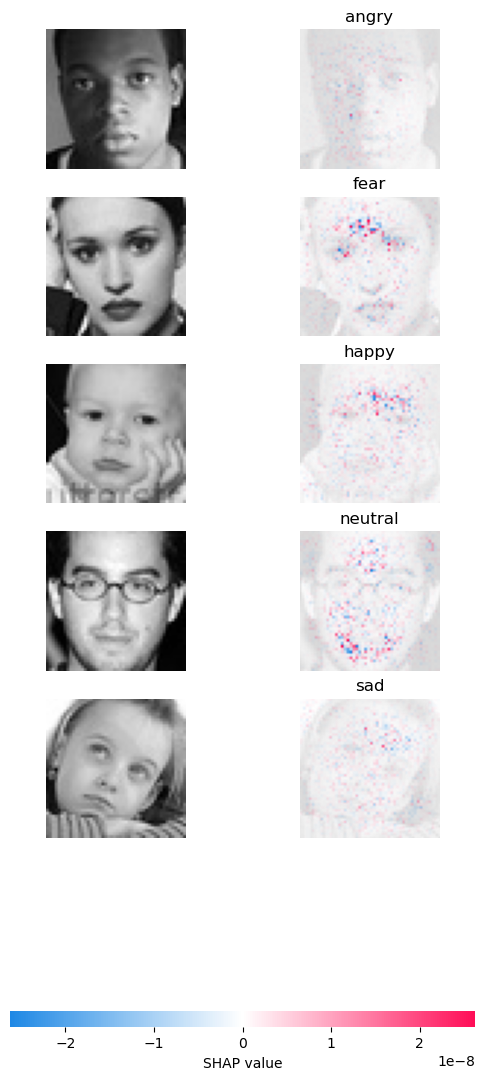

In [ ]:
test_batch = next(validation_generator)
images_to_explain = test_batch[0][:5]  # 5 images
true_labels = np.argmax(test_batch[1][:5], axis=1)

shap_values = explainer.shap_values(images_to_explain)

class_names = list(validation_generator.class_indices.keys())

print("SHAP Visualizations")
print("Red pixels = Increase probability of the class")
print("Blue pixels = Decrease probability of the class\n")

shap.image_plot(shap_values, images_to_explain, labels=np.array(class_names))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Analyzing Error: True Class = 'happy', Model Predicted = 'surprise'
Visualizing contribution maps...


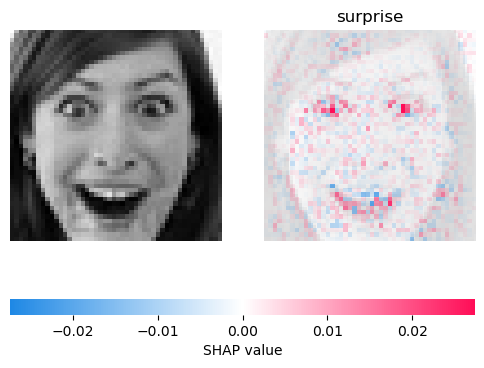

In [93]:
error_indices = np.where(y_pred != y_true)[0]

if len(error_indices) > 0:
    idx = error_indices[0]
    
    bad_image_data = next(validation_generator)[0]
    
    test_batch = next(validation_generator)
    batch_imgs = test_batch[0]
    batch_y_true = np.argmax(test_batch[1], axis=1)
    batch_preds = np.argmax(model.predict(batch_imgs), axis=1)
    
    batch_errors = np.where(batch_preds != batch_y_true)[0]
    
    if len(batch_errors) > 0:
        err_idx = batch_errors[0]
        image_to_explain = batch_imgs[err_idx:err_idx+1]
        
        true_label = class_labels[batch_y_true[err_idx]]
        pred_label = class_labels[batch_preds[err_idx]]
        
        print(f"Analyzing Error: True Class = '{true_label}', Model Predicted = '{pred_label}'")
        
        shap_values, indexes = explainer.shap_values(image_to_explain, ranked_outputs=2)
        
        index_names = np.vectorize(lambda x: class_labels[x])(indexes)
        
        print("Visualizing contribution maps...")
        shap.image_plot(shap_values, image_to_explain, index_names)
    else:
        print("No errors found in this specific batch.")
else:
    print("Model achieved 100% accuracy on the full validation set.")

Global SHAP analysis


c:\Users\kasia\anaconda3\envs\master_models\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=['Tensor(shape=(64, 48, 48, 1))']
  warnings.warn(msg)


SHAP shape: (64, 48, 48, 1, 1), Data shape: (64, 48, 48, 1)
Flattened SHAP shape: (64, 2304)

Generating Beeswarm Plot...


C:\Users\kasia\AppData\Local\Temp\ipykernel_17572\3999311813.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_flat, X_batch_flat, plot_type="dot", max_display=20)


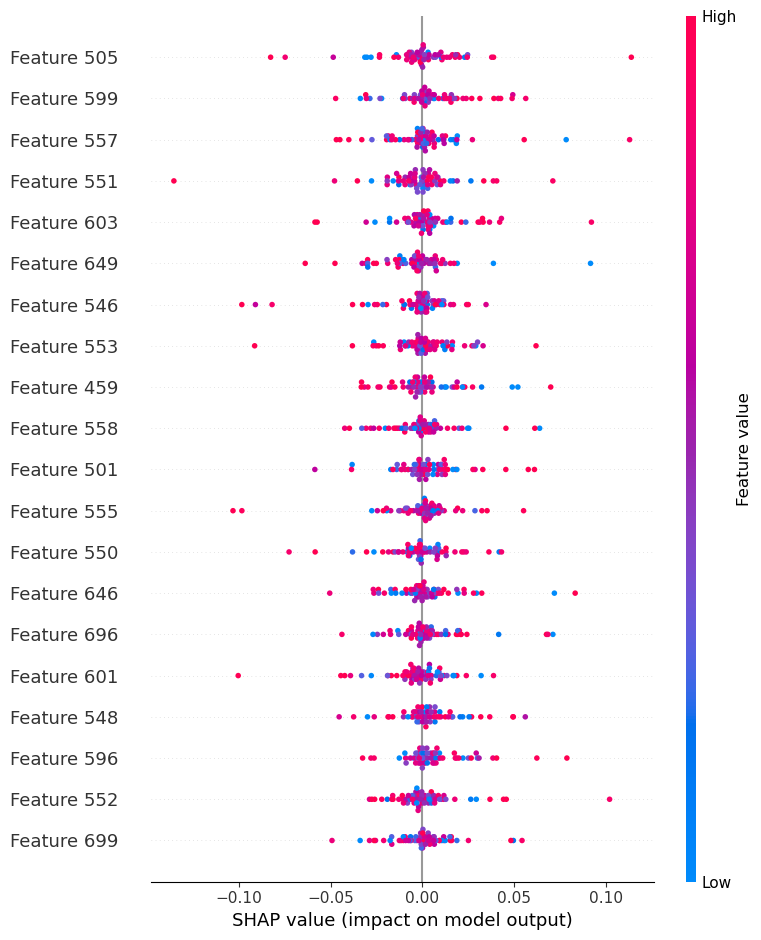


Generating Bar Plot...


C:\Users\kasia\AppData\Local\Temp\ipykernel_17572\3999311813.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_flat, X_batch_flat, plot_type="bar", max_display=20)


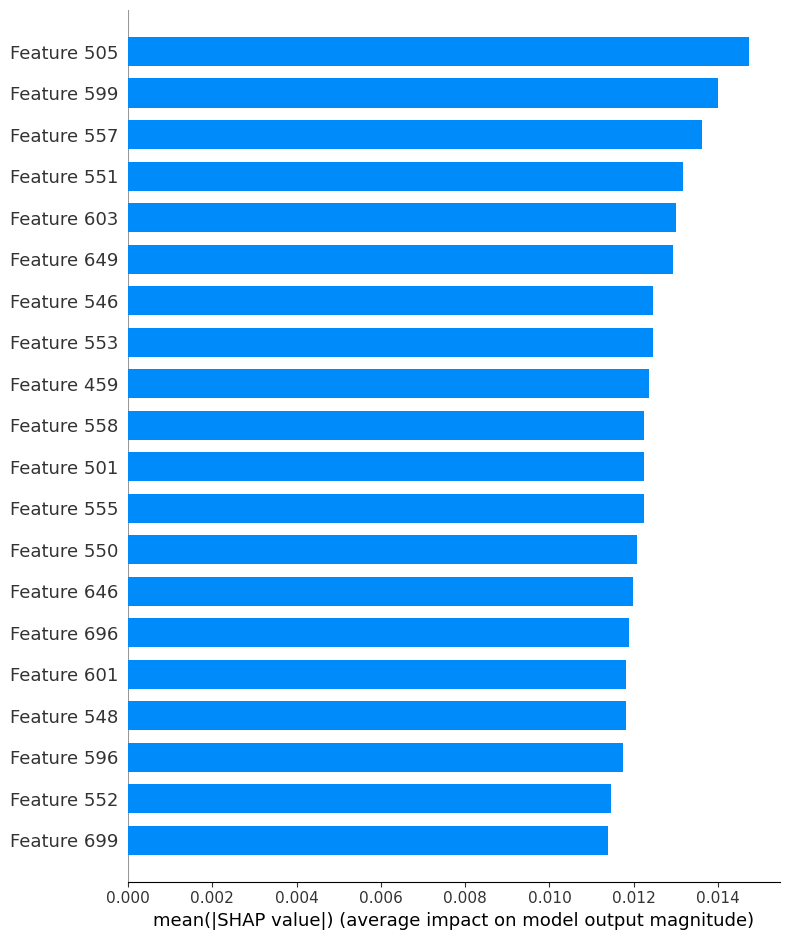

In [77]:
print("Global SHAP analysis")

batch = next(validation_generator)
X_batch = batch[0][:500]  # 500 images

shap_values, indexes = explainer.shap_values(X_batch, ranked_outputs=1)

if isinstance(shap_values, list):
    shap_values_data = shap_values[0]
else:
    shap_values_data = shap_values

print(f"SHAP shape: {shap_values_data.shape}, Data shape: {X_batch.shape}")

shap_values_flat = shap_values_data.reshape(shap_values_data.shape[0], -1)
X_batch_flat = X_batch.reshape(X_batch.shape[0], -1)

print(f"Flattened SHAP shape: {shap_values_flat.shape}")

print("\nGenerating Beeswarm Plot...")
plt.figure()
shap.summary_plot(shap_values_flat, X_batch_flat, plot_type="dot", max_display=20)

print("\nGenerating Bar Plot...")
plt.figure()
shap.summary_plot(shap_values_flat, X_batch_flat, plot_type="bar", max_display=20)